In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from scipy.stats import stats

In [3]:
shootings = pd.read_csv('gva_mass_shootings-2025-10-21.csv')
shootings

,incident_id,incident_date,incident_time,updated_date,state,city_or_county,address,business_location_name,latitude,longitude,...,injured,victims_killed,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics,sources,date_fixed,year
0,809048,"April 1, 2017",NaN,1491348530,Florida,Tampa,219 S Howard Ave,Palace Lounge,27.9431,-82.4831,...,4,1,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://wfla.com/2017/04/01/tampa-police-inv...",2017-04-01,2017
1,809499,"April 1, 2017",5:25 AM,1680156402,Oklahoma,Oklahoma City,1212 N Woodward Ave,NaN,35.4810,-97.5754,...,3,2,3,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.news9.com/story/35055747/okc-pol...",2017-04-01,2017
2,809815,"April 1, 2017",NaN,1492995601,California,Pittsburg,100 block of Madoline Street,NaN,38.0053,-121.8950,...,5,0,5,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.nbcbayarea.com/news/local/Shooting-...,2017-04-01,2017
3,1082835,"April 1, 2018",2:15 AM,1522693801,Michigan,Saginaw,600 block of Yale St,NaN,43.4192,-83.9819,...,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.mlive.com/news/saginaw/index.ssf/20...,2018-04-01,2018
4,1083011,"April 1, 2018",NaN,1646889853,Alabama,Mobile,3556 Halls Mill Rd,Grand Hall,30.6387,-88.1228,...,4,1,4,0,0,3,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.al.com/news/mobile/index.ssf/201...",2018-04-01,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,2411007,"September 9, 2022",4:50 PM,1722738993,New York,Bronx,810 Astor Ave,Pelham Parkway Houses,40.8592,-73.8634,...,4,0,4,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...","c(""https://twitter.com/NYC_Alerts911/status/15...",2022-09-09,2022
5464,2411901,"September 9, 2022",11:50 PM,1689272621,Minnesota,Minneapolis,328 W Broadway Ave,4th Street Saloon,44.9994,-93.2848,...,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""https://www.fox9.com/news/2-pregnant-women-...",2022-09-09,2022
5465,2410446,"September 9, 2022",9:00 AM,1715920831,Maryland,Elk Mills,47 Hebron Ct,NaN,39.6611,-75.8365,...,0,4,0,1,0,0,"Shot - Dead (murder, accidental, or suicide), ...","c(""https://www.cbsnews.com/baltimore/news/five...",2022-09-09,2022
5466,2703975,"September 9, 2023",11:30 PM,1694472936,South Carolina,Rock Hill,800 block of Brunswick Dr,NaN,34.8921,-81.0411,...,4,0,4,0,0,2,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",https://www.heraldonline.com/news/local/crime/...,2023-09-09,2023


In [4]:
# Add csv for gini coefficient by yearSplit first row by ;, and unify column names to lowercase with underscores
df2 = pd.read_csv("gini.csv", sep=';')
df2 = df2.rename(columns={'Unnamed: 3': 'gini_coefficient'})
df2.columns = [c.lower().replace(' ', '_') for c in df2.columns]

# Updating name of DC to match in both dataframes
df2['state'].replace({"Dist. of Columbia": "District of Columbia"}, inplace=True)

# Merging dataframes on year and state
df_merged = pd.merge(left = shootings, right = df2, left_on=['year', 'state'], right_on=['year', 'state'], how='left')

# Deleting unnecessary index column from right dataframe
del df_merged['unnamed:_0']

# Clean gini_coefficient column by multiplying numbers above 1 by 0.001 (Gini coefficient should be between 0 and 1)
df_merged['gini_coefficient'] = df_merged['gini_coefficient'].apply(lambda x: x * 0.001 if x > 1 else x)

# Getting the mean gini coefficient by state
df_gini_mean = df_merged.groupby('state')['gini_coefficient'].mean()

# Updating all states missing gini coefficient with the mean gini coefficient of that state
for state in df_gini_mean.index:
    mean_gini = df_gini_mean[state]
    df_merged["gini_coefficient"].fillna(value=mean_gini, inplace=True)

# Adding link of Wikipedia page for poverty in each state, and preparing for web scraping
url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_poverty_rate#cite_note-CensusData-1"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content)
table = soup.find("tbody")

# Defining labels for dataframe:
labels = [label.get_text() for label in table.find_all("a")]

# Getting values for dataframe:
values = table.find_all("td")
list_values = values[1:len(values):5]
for values in list_values:
    value = float(values.get_text().replace("\n",""))


# Iterating through labels and values to create a dataframe
poverty_data = {}
for key, value in zip(labels, list_values):
    poverty_data[key] = value

# Create dataframe for poverty levels in different states
df_poverty = pd.DataFrame.from_dict(poverty_data, orient='index', columns=['poverty_rate_2025'])

# Updating states with column for poverty rates in states in 2025 and making the poverty rate a float
df_merged = pd.merge(left=df_merged, right=df_poverty, left_on='state', right_index=True, how='left')
df_merged['poverty_rate_2025'] = df_merged['poverty_rate_2025'].astype(float)
df_merged

/var/folders/wc/048rx86x7bqbzmjn7nr46j_80000gn/T/ipykernel_13886/2438076758.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['state'].replace({"Dist. of Columbia": "District of Columbia"}, inplace=True)
/var/folders/wc/048rx86x7bqbzmjn7nr46j_80000gn/T/ipykernel_13886/2438076758.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

,incident_id,incident_date,incident_time,updated_date,state,city_or_county,address,business_location_name,latitude,longitude,...,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics,sources,date_fixed,year,gini_coefficient,poverty_rate_2025
0,809048,"April 1, 2017",NaN,1491348530,Florida,Tampa,219 S Howard Ave,Palace Lounge,27.9431,-82.4831,...,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://wfla.com/2017/04/01/tampa-police-inv...",2017-04-01,2017,0.4859,12.3
1,809499,"April 1, 2017",5:25 AM,1680156402,Oklahoma,Oklahoma City,1212 N Woodward Ave,NaN,35.4810,-97.5754,...,3,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.news9.com/story/35055747/okc-pol...",2017-04-01,2017,0.4658,15.9
2,809815,"April 1, 2017",NaN,1492995601,California,Pittsburg,100 block of Madoline Street,NaN,38.0053,-121.8950,...,5,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.nbcbayarea.com/news/local/Shooting-...,2017-04-01,2017,0.4866,12.0
3,1082835,"April 1, 2018",2:15 AM,1522693801,Michigan,Saginaw,600 block of Yale St,NaN,43.4192,-83.9819,...,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.mlive.com/news/saginaw/index.ssf/20...,2018-04-01,2018,0.4679,13.5
4,1083011,"April 1, 2018",NaN,1646889853,Alabama,Mobile,3556 Halls Mill Rd,Grand Hall,30.6387,-88.1228,...,4,0,0,3,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.al.com/news/mobile/index.ssf/201...",2018-04-01,2018,0.4859,15.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,2411007,"September 9, 2022",4:50 PM,1722738993,New York,Bronx,810 Astor Ave,Pelham Parkway Houses,40.8592,-73.8634,...,4,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...","c(""https://twitter.com/NYC_Alerts911/status/15...",2022-09-09,2022,0.5208,14.2
5464,2411901,"September 9, 2022",11:50 PM,1689272621,Minnesota,Minneapolis,328 W Broadway Ave,4th Street Saloon,44.9994,-93.2848,...,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""https://www.fox9.com/news/2-pregnant-women-...",2022-09-09,2022,0.4560,9.3
5465,2410446,"September 9, 2022",9:00 AM,1715920831,Maryland,Elk Mills,47 Hebron Ct,NaN,39.6611,-75.8365,...,0,1,0,0,"Shot - Dead (murder, accidental, or suicide), ...","c(""https://www.cbsnews.com/baltimore/news/five...",2022-09-09,2022,0.4589,9.5
5466,2703975,"September 9, 2023",11:30 PM,1694472936,South Carolina,Rock Hill,800 block of Brunswick Dr,NaN,34.8921,-81.0411,...,4,0,0,2,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",https://www.heraldonline.com/news/local/crime/...,2023-09-09,2023,0.4715,13.9


In [5]:
# total of killed, injured and total victims by state:
df_state_summary = df_merged.groupby('state').agg({'killed': 'sum', 'injured': 'sum'})
df_state_summary["total_victims"] = df_state_summary['killed'] + df_state_summary['injured']
df_state_summary["gini_coefficient"] = df_merged.groupby('state')['gini_coefficient'].mean()
df_state_summary["poverty_rate_2025"] = df_merged.groupby('state')['poverty_rate_2025'].mean()
df_state_summary

,killed,injured,total_victims,gini_coefficient,poverty_rate_2025
state,,,,,
Alabama,163,635,798,0.481598,15.6
Alaska,8,20,28,0.464265,10.4
Arizona,88,246,334,0.468690,12.4
Arkansas,67,297,364,0.478161,15.7
California,552,1873,2425,0.488129,12.0
Colorado,117,345,462,0.463406,9.3
Connecticut,15,154,169,0.491554,10.3
Delaware,13,81,94,0.462499,10.5
District of Columbia,56,392,448,0.512948,14.0


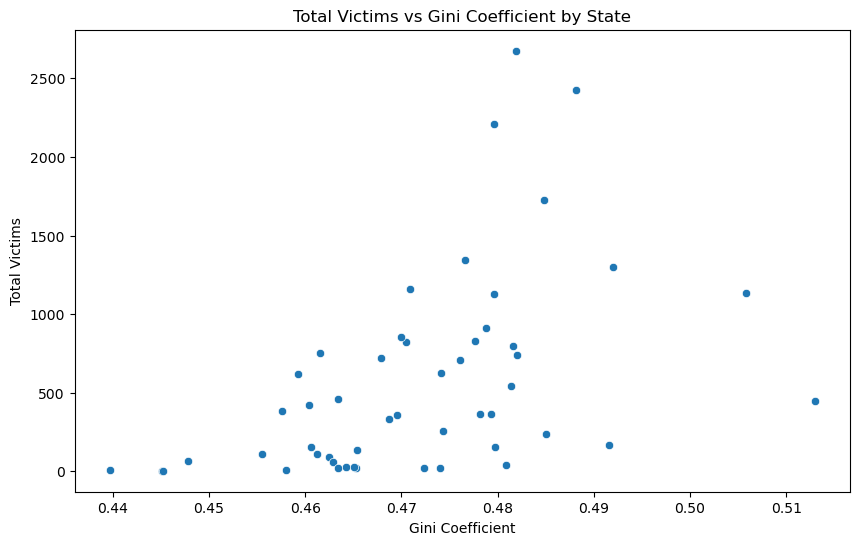

In [6]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_state_summary, x='gini_coefficient', y='total_victims')
plt.title('Total Victims vs Gini Coefficient by State')
plt.xlabel('Gini Coefficient')
plt.ylabel('Total Victims')
plt.show()